# 데이터 전처리 과정

## 순서
1. 데이터 로드
2. 카카오 API를 사용한 위도, 경도 추가 함수 정의
3. GeoJson을 사용한 행정동 계산 함수 정의
4. 원본 데이터프레임으로부터 위도, 경도, 행정동, 단위면적가격을 추가하는 전처리기 정의


### 1. 데이터 로드
가장 중요한 데이터인 집값 데이터를 분석합니다. 이 프로젝트에서는 단독다가구 주택의 월세, 아파트의 매매가를 사용합니다.

1.단독다가구 주택 및 아파트 매매가의 데이터를 분석합니다.

![단독다가구 데이터.png](<attachment:단독다가구 데이터.png>)

![아파트 매매 데이터.png](<attachment:아파트 매매 데이터.png>)

데이터를 직접 열어보면 헤더가 index=12 에 위치하는 것을 볼 수 있습니다.
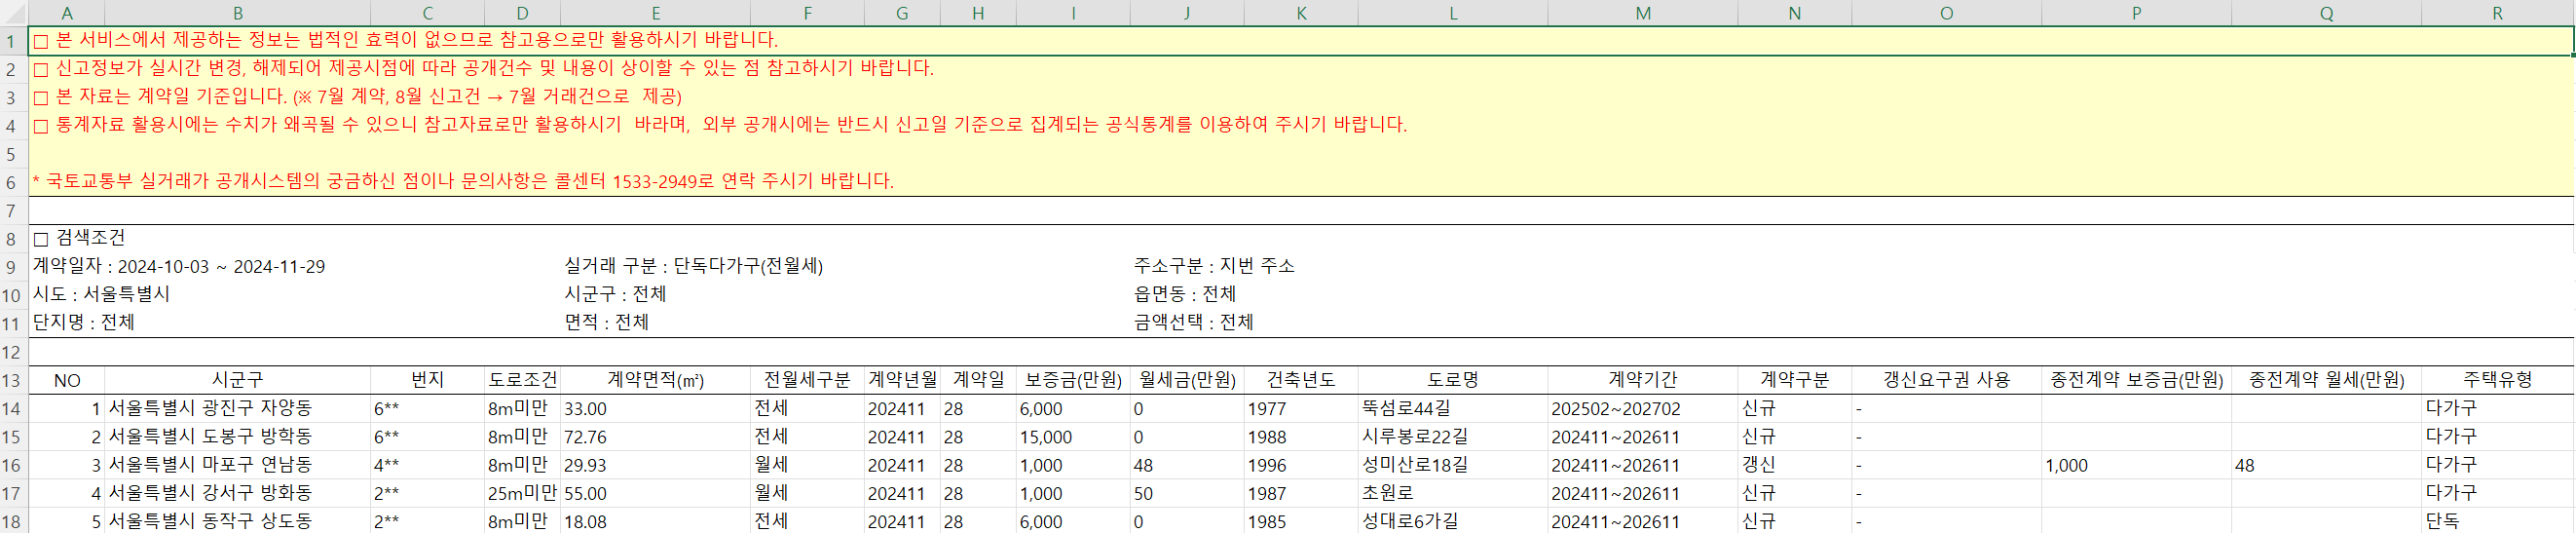
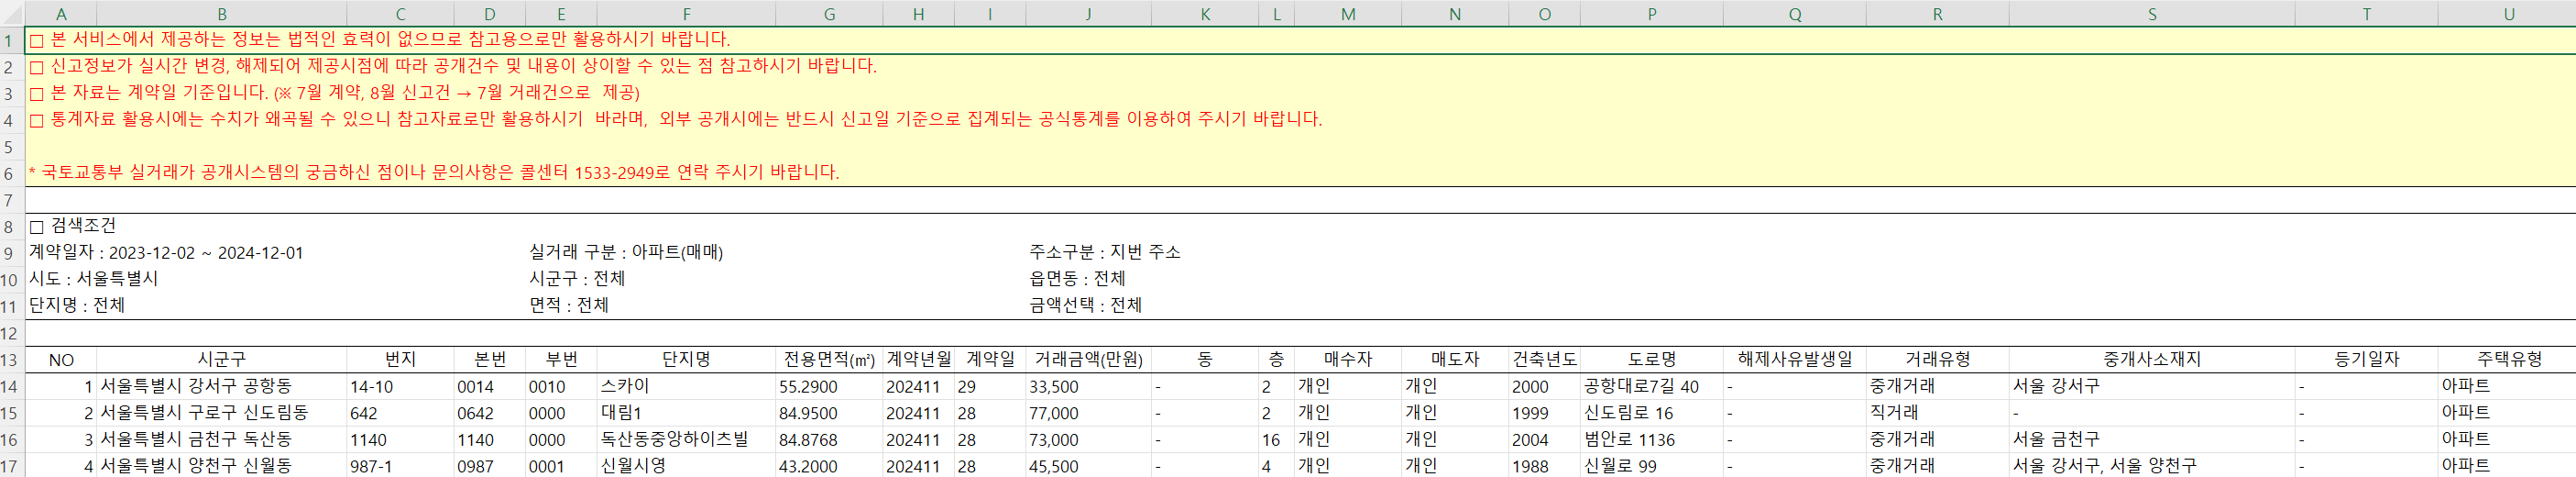

In [ ]:
import pandas as pd

api_key = "****"

#헤더를 12에 설정합니다.
rent_df = pd.read_excel('Datas/전월세 데이터/단독다가구/단독다가구(전월세)_실거래가_20241201034300.xlsx', header=12)
apartment_df = pd.read_excel('Datas/아파트 매매 데이터/아파트(매매)_실거래가_20241201000540.xlsx', header=12)

print(rent_df.head())
print(apartment_df.head())

g:\Housing_Prices_BigData\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
g:\Housing_Prices_BigData\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


   NO            시군구   번지  도로조건  계약면적(㎡) 전월세구분    계약년월  계약일 보증금(만원) 월세금(만원)  \
0   1   서울특별시 중구 신당동  3**  8m미만    33.00    전세  202411   29  11,000       0   
1   2  서울특별시 성동구 마장동  3**  8m미만    35.25    월세  202411   29   2,500      60   
2   3   서울특별시 중구 신당동   5*  8m미만    46.33    월세  202411   29   2,000      80   
3   4  서울특별시 용산구 보광동  2**  8m미만    51.50    전세  202411   29  35,000       0   
4   5   서울특별시 중구 신당동  4**  8m미만    22.00    월세  202411   29   3,000      75   

     건축년도      도로명           계약기간 계약구분 갱신요구권 사용 종전계약 보증금(만원) 종전계약 월세(만원) 주택유형  
0  1991.0  다산로33라길  202407~202607   갱신        -       10,000           0  다가구  
1  1992.0   마조로16길  202411~202611   신규        -          NaN         NaN   단독  
2  1994.0  다산로36다길  202501~202701   신규        -          NaN         NaN  다가구  
3  1992.0   보광로31길  202411~202611   신규        -          NaN         NaN  다가구  
4  2017.0  동호로11가길  202411~202611   신규        -          NaN         NaN  다가구  
   NO             시군구     번지    본번  부번       

In [2]:
print(rent_df.columns)

Index(['NO', '시군구', '번지', '도로조건', '계약면적(㎡)', '전월세구분', '계약년월', '계약일', '보증금(만원)',
       '월세금(만원)', '건축년도', '도로명', '계약기간', '계약구분', '갱신요구권 사용', '종전계약 보증금(만원)',
       '종전계약 월세(만원)', '주택유형'],
      dtype='object')


데이터가 정상적으로 출력됨을 알 수 있습니다.   
그러나 가장 기준이 되는 행정동 열이 없습니다. 시각화의 기준은 행정동이므로 도로명주소에서 경도와 위도를 추출해야 합니다.   
다음과 단계에서 경도와 위도를 추출합니다.   

### 2. 카카오 API를 사용한 위도, 경도 추가 함수 정의
카카오 API를 사용하여 위도와 경도를 데이터프레임에 추가하는 함수를 정의합니다.

In [3]:
from tqdm import tqdm
import pandas as pd
import requests
import os
import requests

##api 요청을 하는 함수.
def get_geocoding_api(place, api_key):
    ##카카오 api 엔드포인트 설정
    url = f"https://dapi.kakao.com/v2/local/search/address.json?query={place}"
    headers = {"Authorization": f"KakaoAK {api_key}"}

    ##api요청이 성공하면 위도와 경도를 받아오고 실패하면 nan을 대입
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        result = response.json()
        if result["documents"]:
            return result["documents"][0]["y"], result["documents"][0]["x"]
    return None, None


##원본 데이터프레임에 위도와 경도를 추가하는 함수
def get_location(df: pd.DataFrame, location_column: str, api_key: str, cache_file: str = "location_cache.csv") -> pd.DataFrame:
    ##캐시 파일이 있는 지 확인. 있다면 읽어들임.
    if os.path.exists(cache_file):
        cache_df = pd.read_csv(cache_file)
    else:
        cache_df = pd.DataFrame(columns=["주소", "위도", "경도"])

    ##캐시 파일 내부에 중복을 제외한 주소 파악
    cached_addresses = set(cache_df["주소"])

    ##원본 데이터프레임 내부에 중복은 제외한 주소 파악
    unique_addresses = set(df[location_column])

    ##새로 요청해야 할 주소들만 추출
    new_addresses = unique_addresses - cached_addresses

    ##api 함수를 사용하여 새로운 주소에 대한 경도와 위도를 가져옴.
    new_data = []
    for address in tqdm(new_addresses, desc="Fetching new addresses"):
        lat, lng = get_geocoding_api(address, api_key)
        if lat and lng is not None:
            new_data.append({"주소": address, "위도": lat, "경도": lng})

    ##모든 파일에 대해 동일한 작업을 수행한 후 연결
    new_df = pd.DataFrame(new_data)
    updated_cache_df = pd.concat([cache_df, new_df], ignore_index=True)

    ##새로운 주소 캐시를 캐시 파일에 저장
    updated_cache_df.to_csv(cache_file, index=False)

    ##정제된 데이터프레임을 재사용할 수 있도록 저장.
    result_df = df.merge(updated_cache_df, left_on=location_column, right_on="주소", how="left")

    return result_df

위 함수에서는 각 주택과 아파트의 경도와 위도만을 api로 가져옵니다. 행정동을 파악하려면 경도와 위도를 사용하여 해당 위치가 어느 행정동에 위치하는 지 판별해야 합니다.   
다음 단계에서 원본 데이터프레임의 위도와 경도를 사용해 해당하는 행정동을 추가합니다.   

### 3. GeoJson을 사용한 행정동 계산 함수 정의
위도와 경도, GeoJson 파일을 사용하여 그 위치가 어떤 행정동에 위치하는 지 계산합니다.

In [4]:
import geopandas as gpd
from shapely.geometry import Point
import json
import chardet
from tqdm import tqdm

def convert_dong_type(df, geojson_path):
    import json
    from shapely.geometry import Point
    import geopandas as gpd
    from tqdm import tqdm

    ##GeoJSON 파일 로드 (UTF-8 인코딩)
    with open(geojson_path, encoding='utf-8') as f:
        geojson_data = json.load(f)

    ##GeoDataFrame으로 변환
    gdf = gpd.GeoDataFrame.from_features(geojson_data["features"])

    ##'dong_name' 필드가 GeoJSON에 포함되어 있어야 함
    # if 'dong_name' not in gdf.columns:
    #     raise ValueError("GeoJSON 파일에 'dong_name' 필드가 포함되어 있지 않습니다.")

    ##DataFrame에 '행정동' 열 추가
    df['행정동'] = None

    ##각 행의 경도와 위도를 처리
    for index, row in tqdm(df.iterrows(), desc='법정동-행정동 변환 중...'):
        longitude = row['경도']
        latitude = row['위도']
        point = Point(longitude, latitude)

        ##각 점이 어떤 행정동에 속하는지 판별
        found_dong = None
        for _, geo_row in gdf.iterrows():
            if geo_row['geometry'].contains(point):
                found_dong = geo_row['dong_name']
                break

        ##'행정동' 열에 결과 저장
        df.at[index, '행정동'] = found_dong if found_dong else "Unknown"

    ##결과 반환
    return df

위 함수를 사용하여 단독다가구 주택과 아파트 매매가의 전처리기를 정의합니다.   
이 함수에서는 가장 중요한 요소인 단위면적가격을 계산합니다.

### 3. 원본 데이터프레임으로부터 위도, 경도, 행정동, 단위면적가격을 추가하는 전처리기 정의


In [5]:
def get_files(house_type):
    ##Main.py 경로
    base_dir = os.getcwd()
    filepath = os.path.join(base_dir, 'Datas', '전월세 데이터', house_type)
    filelist = []

    if os.path.exists(filepath):
        for root, dirs, files in os.walk(filepath):
            for file in files:
                filelist.append(os.path.join(root, file))
    else:
        print(f"Directory '{filepath}' does not exist.")
    return filelist

def housing_monthlyrent_price_preprocessor(count, api_key):
    filelist = get_files('단독다가구')

    ##빈 데이터프레임 초기화
    combined_df = pd.DataFrame()


    ##파일 하나씩 읽어와서 합치기
    for file in filelist:
        try:
            df = pd.read_excel(file, header=12)
            ##도로명이 없다면 의미가 없으므로 제거
            df.dropna(subset='도로명',inplace=True)
            ##전세, 월세 중 월세 데이터만 추출
            df = df[df['전월세구분'] == '월세']

            ##월세금과 계약면적은 숫자이므로 타입 변경
            df['월세금(만원)'] = df['월세금(만원)'].str.replace(",", "").astype(float)  # 쉼표 제거 후 float 변환
            df['계약면적(㎡)'] = df['계약면적(㎡)'].astype(float)  # float 변환
            ##단위면적가격 계산
            df['단위면적가격'] = df['월세금(만원)'] / df['계약면적(㎡)']
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        except Exception as e:
            print(f"Error processing file {file}: {e}")

    ##데이터 제한(데이터가 30만개 이상일 때, 카카오 API 서버의 하루 할당량 초과)
    combined_df = combined_df.iloc[:count]

    ##상세주소로 위도, 경도 데이터 가져오기
    combined_df = get_location(combined_df, '도로명', api_key)
    combined_df = convert_dong_type(combined_df, 'Datas/행정구역/hangjeongdong_서울특별시_with_dong_name.geojson')

    ##이상치 제거, 백분율 25%~75% 값을 사용.
    Q1 = combined_df['단위면적가격'].quantile(0.25)
    Q3 = combined_df['단위면적가격'].quantile(0.75)
    IQR = Q3 - Q1
    combined_df = combined_df[(combined_df['단위면적가격'] >= (Q1 - 1.5 * IQR)) &
                              (combined_df['단위면적가격'] <= (Q3 + 1.5 * IQR))]

    ##결측값 제거
    combined_df.dropna(how='any',subset=['단위면적가격','경도','위도','행정동'],inplace=True)

    combined_df.to_csv('Datas/Refined_Datas/rent_df.csv')
    return combined_df



##아파트 매매 데이터 전처리기
def apartment_trade_preprocessor(count, api_key):
    ##아파트 매매 데이터 읽기
    df = pd.read_excel('Datas/아파트 매매 데이터/아파트(매매)_실거래가_20241201000540.xlsx',header=12)
    ##데이터 수 제한하기
    df = df.iloc[:count]

    ##데이터 타입 변경
    df['거래금액(만원)'] = df['거래금액(만원)'].str.replace(",", "").astype(float)  # 쉼표 제거 후 float 변환
    df['전용면적(㎡)'] = df['전용면적(㎡)'].astype(float)  # float 변환

    ##단위면적가격 계산
    df['단위면적가격'] = df['거래금액(만원)'] / df['전용면적(㎡)']

    ##API함수와 행정동 변환기를 사용하여 경도와 위도, 행정동 열을 추가
    df = get_location(df, '도로명', api_key)
    df = convert_dong_type(df, 'Datas/행정구역/hangjeongdong_서울특별시_with_dong_name.geojson')

    ##결측값 제거
    df.dropna(how='any',subset=['단위면적가격','경도','위도','행정동'],inplace=True)

    ##이후 재사용을 위해 데이터 저장
    df.to_csv('Datas/Refined_Datas/apartment_df.csv')

    ##완성된 데이터프레임 반환
    return df


이제 위의 전처리기를 사용하여 데이터를 테스트합니다. 각 데이터에서 행 10개를 처리합니다.

In [6]:
rent_df = housing_monthlyrent_price_preprocessor(10, api_key)
apartment_df = apartment_trade_preprocessor(10, api_key)

print(rent_df[['시군구','번지','단위면적가격','경도','위도','행정동']].head())
print(apartment_df[['시군구','번지','단위면적가격','경도','위도','행정동']].head())

g:\Housing_Prices_BigData\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
Fetching new addresses: 0it [00:00, ?it/s]
법정동-행정동 변환 중...: 10it [00:00, 1176.79it/s]
g:\Housing_Prices_BigData\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
Fetching new addresses: 0it [00:00, ?it/s]
법정동-행정동 변환 중...: 10it [00:00, 252.01it/s]

             시군구   번지    단위면적가격          경도         위도  행정동
0  서울특별시 성동구 마장동  3**  1.702128  127.043695  37.564788  마장동
1   서울특별시 중구 신당동   5*  1.726743  127.019971  37.560154  동화동
2   서울특별시 중구 신당동  4**  3.409091  127.008376  37.553052  다산동
3  서울특별시 용산구 후암동  3**  1.156292  126.981767  37.547292  후암동
4  서울특별시 종로구 혜화동   7*  2.727273  127.001339  37.588463  혜화동
              시군구     번지       단위면적가격          경도         위도   행정동
0   서울특별시 강서구 공항동  14-10   605.896184  126.813617  37.562589   공항동
1  서울특별시 구로구 신도림동    642   906.415539  126.882191  37.505123  신도림동
2   서울특별시 금천구 독산동   1140   860.070125  126.888537  37.465331  독산1동
3   서울특별시 양천구 신월동  987-1  1053.240741  126.835157  37.518416  신월7동
4   서울특별시 노원구 상계동    666  1001.201442  127.056125  37.661652  상계8동


## 요약   
1.원본 데이터를 분석하여 헤더의 위치를 파악합니다.   
2.카카오 api 를 사용하여 각 주소의 위도와 경도를 추출합니다.   
3.각 위도와 경도를 사용하여 geojson 파일로부터 행정동을 계산합니다.   
4.주택과 아파트 데이터로부터 단위면적가격을 계산합니다.   
5.전처리기는 완성된 데이터프레임을 반환합니다.   
